In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_60 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *

import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()


In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

# ## load the inbalanced dataset sampler
# labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=16,sampler=train_sampler,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=16,sampler=val_sampler,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=16,sampler=test_sampler,collate_fn=collate_fn )
train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [ ]:
# from torch.utils.data import Subset


# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=False,collate_fn=collate_fn )

# batch = next(iter(train_loader))
# *_, original_indices = batch
# small_ids = original_indices.tolist()

# small_subset = Subset(dataset_train, small_ids)

# small_train_loader = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=True,
#     collate_fn=collate_fn
# )
# small_train_loader_p = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=False,
#     collate_fn=collate_fn
# )

In [3]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_60/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [9]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_60_eachtime"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_60_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            gamma=150, beta=10, kappa=10, eta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


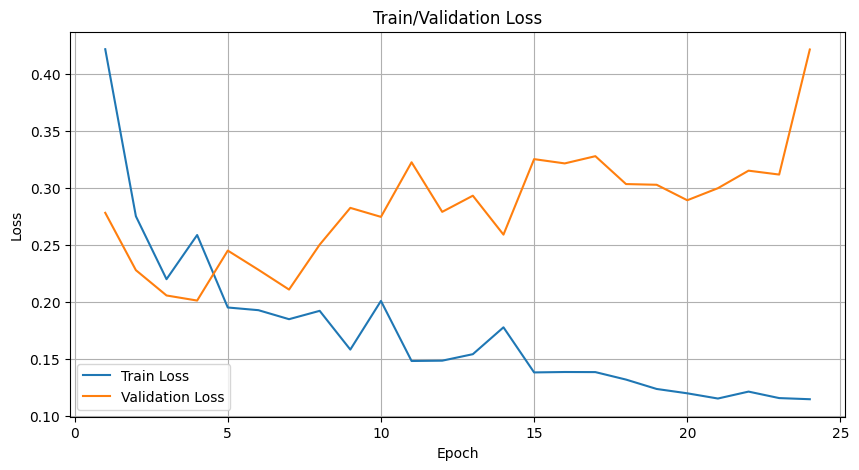

In [6]:
plot_training_history(history)

In [12]:

def test_patient_outcome_model(model, test_loader, device):
    model.eval()
    
    all_mort_preds, all_mort_trues = [], []

    # 记录 per-patient loss
    per_patient_mort_losses = []
    per_patient_cats = []

    with torch.no_grad():
        for _, flat_data, ts_data, graph_data, risk, ts_lengths, categories, mortality, _ in test_loader:
            flat_data, ts_data, ts_lengths = flat_data.to(device), ts_data.to(device), ts_lengths.to(device)
            graph_data = graph_data.to(device)
            categories = categories.to(device)
            y_risk_true, y_mortality_true = risk.to(device), mortality.to(device)

            output = model(flat_data, graph_data, ts_data, ts_lengths)
            mask_seq_bool, _ = model.generate_mask(ts_data.size(1), ts_lengths)
            mask_seq = mask_seq_bool.float()


            
            # 2. Mortality classification
            # mortality_prob_pred = output["mortality_prob"]  # (B, T)
            # mort_preds_flat = mortality_prob_pred.view(-1)[mask_flat].cpu().numpy()
            # mort_trues_flat = y_mortality_true.view(-1)[mask_flat].cpu().numpy()
            # all_mort_preds.extend(mort_preds_flat)
            # all_mort_trues.extend(mort_trues_flat)
            
            B = ts_data.size(0)
            idx = torch.arange(B, device=device)
            last_idx = (ts_lengths - 1).clamp(min=0)  # [B]
            mortality_prob_pred_last = output["mortality_prob"][idx, last_idx]  # [B]
            
            loss_mortality_elementwise = F.binary_cross_entropy(mortality_prob_pred_last, y_mortality_true.float(), reduction='none')  
                      
            per_patient_mort_losses += loss_mortality_elementwise.cpu().tolist()
            
            mortality_prob_pred_last = mortality_prob_pred_last.cpu().numpy()  # [B]
            mortality_true_last = y_mortality_true.cpu().numpy()                              # [B]
            all_mort_preds.extend(mortality_prob_pred_last)
            all_mort_trues.extend(mortality_true_last)


            # 3. per-patient categories    
            per_patient_cats += categories.cpu().tolist()

    # --- 计算分类指标 ---
    # 
    try:
        auroc = roc_auc_score(all_mort_trues, all_mort_preds)
    except:
        auroc = float('nan')
    try:
        auprc = average_precision_score(all_mort_trues, all_mort_preds)
    except:
        auprc = float('nan')
        
    # 以0.5为阈值
    
    precisions, recalls, thresholds = precision_recall_curve(all_mort_trues, all_mort_preds)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    print("Best threshold:", best_thresh, "→ F1:", f1s[best_idx]) 
       
    mort_preds_binary = [1 if p >= best_thresh else 0 for p in all_mort_preds]
    precision = precision_score(all_mort_trues, mort_preds_binary, zero_division=0)
    recall    = recall_score(all_mort_trues, mort_preds_binary, zero_division=0)
    f1        = f1_score(all_mort_trues, mort_preds_binary, zero_division=0)
    
    # Specificity = TN / (TN + FP)
    tn = sum(1 for t, p in zip(all_mort_trues, mort_preds_binary) if t == 0 and p == 0)
    fp = sum(1 for t, p in zip(all_mort_trues, mort_preds_binary) if t == 0 and p == 1)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    # 输出结果
    print("Total test samples:", len(all_mort_trues))
    print("Number of actual deaths:", sum(all_mort_trues))
    print("Predictions range: min=", min(all_mort_preds), " max=", max(all_mort_preds))
    print("Mean predicted death probability:", np.mean(all_mort_preds))      
    
    print(f"Test Mortality - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f},pecificity: {specificity:.4f}, F1: {f1:.4f}")

    # 按类别统计loss
    hist_cat = {}
    losses_t = torch.tensor(per_patient_mort_losses)
    cats_t = torch.tensor(per_patient_cats)
    for i in range(2):
        sel = cats_t == i
        if sel.any():
            group = losses_t[sel]
            hist_cat[i] = (group.mean().item(), int(sel.sum().item()))

    # 返回主要指标
    return {
        "auroc": auroc,
        "auprc": auprc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "per_patient_cat_loss": hist_cat,
    }

In [13]:
output= test_patient_outcome_model(model, test_loader, device)

Best threshold: 0.46692935 → F1: 0.7391304298416824
Total test samples: 461
Number of actual deaths: 51
Predictions range: min= 0.00041191326  max= 0.98538035
Mean predicted death probability: 0.12119421
Test Mortality - AUROC: 0.9409, AUPRC: 0.7520, Precision: 0.8293, Recall: 0.6667,pecificity: 0.9829, F1: 0.7391


In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_60/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

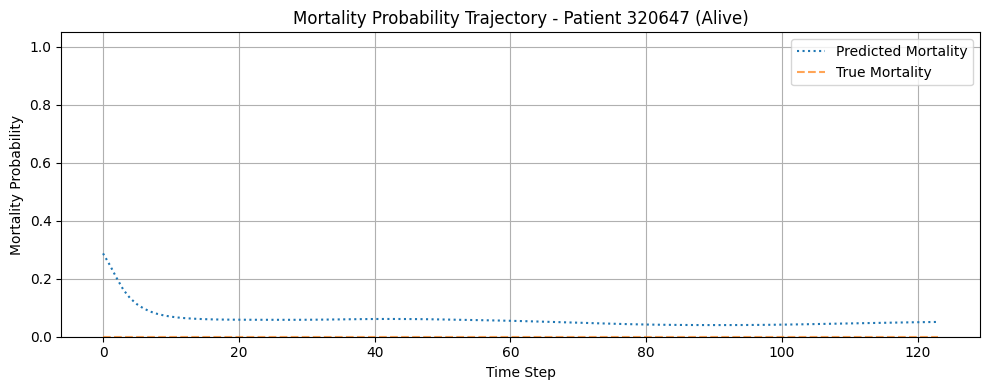

In [5]:
plot_patient_mortality_probability(model, test_loader, patient_index=398, device=device)

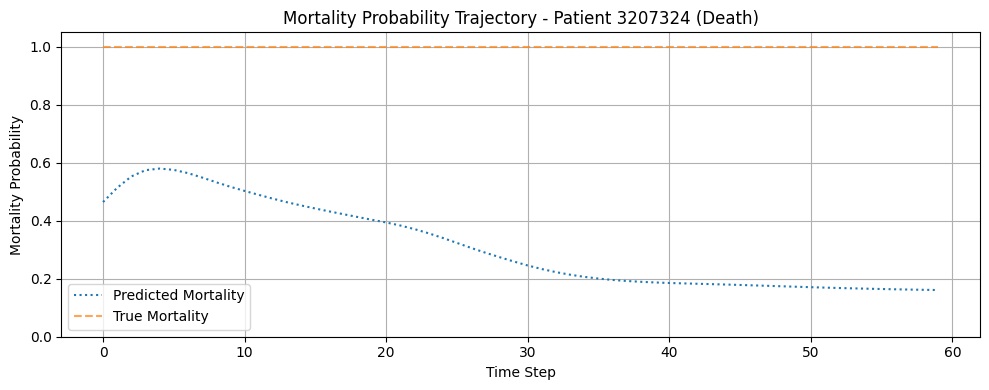

In [6]:
plot_patient_mortality_probability(model, test_loader, patient_index=400, device=device)

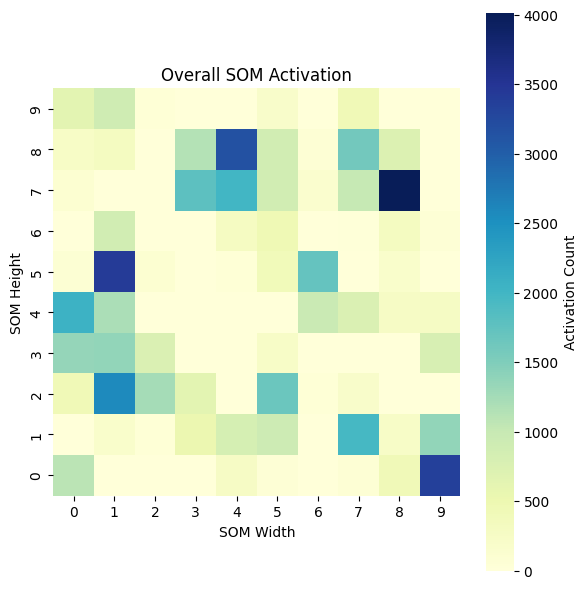

In [7]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

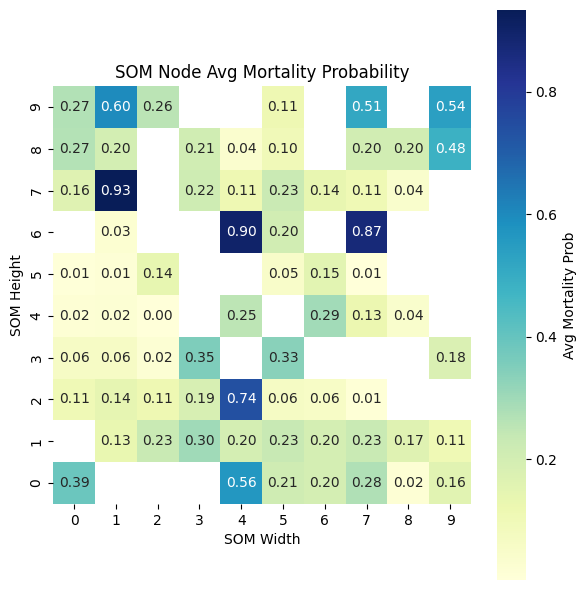

In [11]:
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)
plot_som_avg_mortality_prob(mort_heatmap, som_dim)